In [1]:
%pylab inline
import biff
from scipy import special
import pygadgetreader
import reading_snapshots

Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)


In [3]:
r_s_sims = 40.85
G_gadget=43007.1 #kpc3/(Gyr2Msun)/1E10. 

In [29]:
pot_lmc = pygadgetreader.readsnap('../../MW_anisotropy/code/test_snaps/LMC1_97K_vir_000', 'pot', 'dm')
pos_lmc = pygadgetreader.readsnap('../../MW_anisotropy/code/test_snaps/LMC1_97K_vir_000', 'pos', 'dm')
mass_lmc = pygadgetreader.readsnap('../../MW_anisotropy/code/test_snaps/LMC1_97K_vir_000', 'mass', 'dm')

Returning DM    Potential
Returning DM    Positions
Returning DM    Mass


In [30]:
S_lmc, T_lmc = biff.compute_coeffs_discrete(np.double(pos_lmc), np.double(mass_lmc), 20, 20, 3, compute_var=False)

In [31]:
S_lmc_000 = np.zeros(shape(S_lmc))
S_lmc_000[0,0,0] = S_lmc[0,0,0]
T_lmc_000 = np.zeros(shape(T_lmc))
T_lmc_000[0,0,0] = T_lmc[0,0,0]


In [32]:
pot_lmc_biff = biff.potential(np.double(pos_lmc), S_lmc, T_lmc, G=G_gadget, M=1, r_s=3)

In [33]:
pot_lmc_biff_000 = biff.potential(np.double(pos_lmc), S_lmc_000, T_lmc_000, G=G_gadget, M=1, r_s=3)

In [10]:
rlmc = np.sqrt(pos_lmc[:,0]**2 + pos_lmc[:,1]**2 + pos_lmc[:,2]**2)
r30 = np.where(rlmc<30)[0]

In [11]:
delta_pot = (pot_lmc_biff[r30] - pot_lmc[r30])/pot_lmc[r30] * 100

In [12]:
delta_pot_000 = (pot_lmc_biff_000[r30] - pot_lmc[r30])/pot_lmc[r30] * 100

In [13]:
print(np.mean(delta_pot), np.std(delta_pot))

0.170823230971 0.474215801003


In [14]:
print(np.mean(delta_pot_000), np.std(delta_pot_000))

0.1046770118 0.545739616934


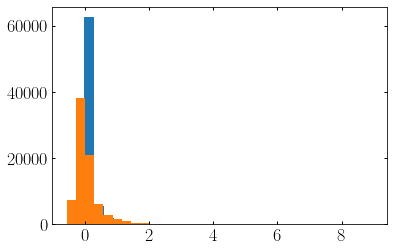

In [15]:
h_diff = hist(delta_pot, 30)
h_diff = hist(delta_pot_000, 30)

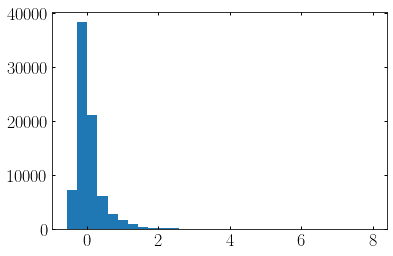

In [16]:
h_diff = hist(delta_pot_000, 30)

In [196]:
def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl

In [487]:
def copy_matrix(M, indices):
    M_new = np.zeros(shape(M))
    for i in range(len(indices[0])):
        M_new[indices[0][i]][indices[1][i]][indices[2][i]] = M[indices[0][i]][indices[1][i]][indices[2][i]]
    return M_new
    
def coefficients_energy_level(S, T, e_cut, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
    n_max = shape(S)[0]
    l_max = shape(S)[1]
    m_max = shape(S)[2]
    
    
    A_nl_array = np.zeros((n_max, l_max))
    for j in range(n_max):
        for i in range(l_max):
            A_nl_array[j][i] = Anl(j, i)
    A_nl_matrix = np.zeros((n_max, l_max, m_max))
    for i in range(m_max):
        A_nl_matrix[:,:,i] = A_nl_array
    
    U_nlm = 0.5*(S**2 + T**2)/A_nl_matrix
    U_all = np.sum(U_nlm)
    energy_cut = np.where(np.log10(np.abs(U_nlm))>np.log10(np.abs(U_all))*e_cut)
    if verb == 1:
        print('\sum U = ',np.log10(np.abs(U_all)))
        print('U cut = ',np.log10(np.abs(U_all))*e_cut)
        print('N coeff = ', len(energy_cut[0]))

    S_new = copy_matrix(S, energy_cut)
    T_new = copy_matrix(T, energy_cut)
    return S_new, T_new, [np.max(energy_cut[0]) ,np.max(energy_cut[1]), np.max(energy_cut[2])]
    
    

In [442]:
S_lmc_95, T_lmc_95, coeff = coefficients_energy_level(S_lmc, T_lmc, 0.95)


\sum U =  0.176667773635
U cut =  0.167834384954
N coeff =  1


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


In [4]:
n_max = l_max = m_max = 21
A_nl_array = np.zeros((n_max, l_max))
for j in range(n_max):
    for i in range(l_max):
        A_nl_array[j][i] = Anl(j, i)
A_nl_matrix = np.zeros((n_max, l_max, m_max))
for i in range(m_max):
    A_nl_matrix[:,:,i] = A_nl_array

In [22]:
U = -0.5*(S_lmc**2 + T_lmc**2)/A_nl_matrix

In [23]:
np.log10(U[0][0][0])

0.17640479172455215

In [24]:
np.sum(U)

1.5019925330408594

In [25]:
U[0][0][0]

1.5010832944616583

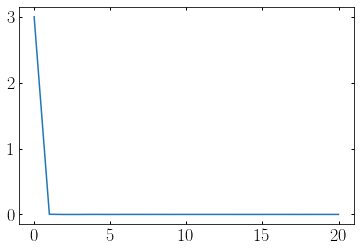

In [26]:
plot(S_lmc[:,0,0])


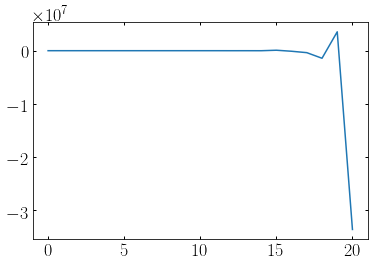

In [27]:
plot(S_lmc[0,:,0])

(-12, 1)

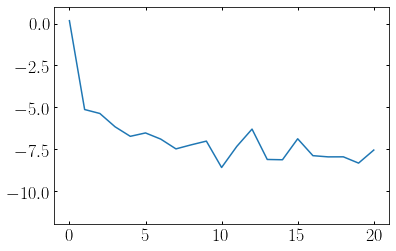

In [28]:
plot(np.log10(U[0,:,0]))
ylim(-12, 1)

In [29]:
## Application to the LMC + MW 

In [6]:
r_s_sims = 40.85

In [102]:
MW_mass = pygadgetreader.readsnap('../../MW_anisotropy/code/test_snaps/MWLMC5_100M_new_b1_110', 'mass', 'dm')

Returning DM    Mass


In [86]:
pos_dm_halo = pygadgetreader.readsnap('./MWLMC5_100M_b1_dmhalopart_1e6_000',  'pos', 'dm')

Returning DM    Positions


In [87]:
pot_dm_halo = pygadgetreader.readsnap('./MWLMC5_100M_b1_dmhalopart_1e6_000',  'pot', 'dm')

Returning DM    Potential


In [80]:
pot[-1]

array([-55686.5390625, -44283.609375 ,  44831.1953125], dtype=float32)

In [81]:
pot[0]

array([-45169.59375  , -50011.8515625, -18282.265625 ], dtype=float32)

In [91]:
MW_post = reading_snapshots.read_MW_snap_com_coordinates('../../MW_anisotropy/code/test_snaps/', 'MWLMC5_100M_new_b1_110', LMC=True,
                                                                 N_halo_part=100000000, pot=True)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Positions
Returning DISK  Velocities
Returning DISK  Potential
Returning DM    Potential
Loading MW particles and LMC particles


In [92]:
## Reading coefficients 
coeff_c = np.loadtxt('../../SCF_tools/PCA/MWLMC5_coeff_20_20_100M_b1.txt')
S = coeff_c[:,0]
T = coeff_c[:,1]

S_matrix = np.zeros((21, 21, 21))
T_matrix = np.zeros((21, 21, 21))


counter = 0
for n in range(21):
    for l in range(21):
        for m in range(0, l+1):
            S_matrix[n][l][m] = S[counter]
            T_matrix[n][l][m] = T[counter]
            counter +=1

In [461]:
def diff_pot(S_all, T_all, q_all, energy_cuts, quantity, rs, M=1, G=43007.1):
    """
    Compute the difference in potential | acceleration | density 
    between BFE reconstructions with coefficients with different energy.
    
    Input:
    -----
    S_all : Matrix with all the S_nlm coefficients
    T_all : Matrix with all the T_nlm coefficients
    q_all : Quantity used to make the comparisson  
            if q_all == 'BFE' a quantity using all the coefficients is computed.
    energy_cuts : list with all the percentage of energy thresholds to find the coefficients.
                    energy_cuts = 0 means all the coefficients energy_cuts = 1 means the
                    most energetic coefficient.
    quantity : str 
        Quantity to be computed either pot, gradient or density
    rs = scale length of the halo
    M : mass of the halo default == 1 (if you compute the coefficients S and T with the 
        the masses of each particles leave this as 1)
    G : Value of the graviational constant. Default is Gadget G
    
    Returns:
    --------
    Mean of the difference.
    standar deviation of the mean.
    order of the coefficients.
    """
    
      
    q_mean = np.zeros(len(energy_cuts))
    q_disp = np.zeros(len(energy_cuts))
    coeff_order = np.zeros((len(energy_cuts),3))
    
    if q_all == 'BFE':
        if quantity == 'potential':
            q_all = biff.potential(np.ascontiguousarray(np.double(pos)), S_all, 
                                   T_all, G=G, M=M , r_s=rs)
        elif quantity == 'gradient':
            q_all = biff.gradient(np.ascontiguousarray(np.double(pos)), S_all, 
                                   T_all, G=G, M=M , r_s=rs)
        elif quantity == 'density':
            q_all = biff.density(np.ascontiguousarray(np.double(pos)), S_all, 
                                   T_all, M=M , r_s=rs)
    
    j=0
    for i in energy_cuts:
        S, T, coeff_order[j] = coefficients_energy_level(S_all, T_all, i)
        
        if quantity == 'potential':
            q_biff = biff.potential(np.ascontiguousarray(np.double(pos)), S, 
                                   T, G=G, M=1, r_s=r_s_sims)
            delta_q = (q_biff - q_all)/q_all * 100
            q_mean[j] = np.mean(delta_q)
            q_disp[j] = np.std(delta_q)
            
        elif quantity == 'gradient':
            q_mean = np.zeros((len(energy_cuts), 3))
            q_disp = np.zeros((len(energy_cuts), 3))
            q_biff = biff.gradient(np.ascontiguousarray(np.double(pos)), S, 
                                   T, G=G, M=1, r_s=r_s_sims)
            
            delta_qx = (q_biff[:,0] - q_all[:,0])/q_all[:,0] * 100
            delta_qy = (q_biff[:,1] - q_all[:,1])/q_all[:,1] * 100
            delta_qz = (q_biff[:,2] - q_all[:,2])/q_all[:,2] * 100

            q_mean[j] = [np.mean(delta_qx), np.mean(delta_qy), np.mean(delta_qz)]
            q_disp[j] = [np.std(delta_qx), np.std(delta_qy), np.std(delta_qz)]
        
        elif quantity == 'density':
            q_biff = biff.density(np.ascontiguousarray(np.double(pos)), S, 
                                   T, M=1, r_s=r_s_sims)
            
            delta_q = (q_biff - q_all)/q_all * 100
            q_mean[j] = np.mean(delta_q)
            q_disp[j] = np.std(delta_q)
            
        j+=1
    return q_mean, q_disp, coeff_order

In [472]:
e_cuts = np.linspace(0.2, 0.9, 20)

In [477]:
pos = MW_post[0][N_particules]

In [478]:
pot_mean_all, pot_disp_all, n = diff_pot(S_matrix, T_matrix, q_all='BFE', energy_cuts=e_cuts, 
                                         quantity='potential', rs = r_s_sims)

\sum U =  15.2044652985
U cut =  3.0408930597
N coeff =  4777


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


\sum U =  15.2044652985
U cut =  3.60105757069
N coeff =  4641
\sum U =  15.2044652985
U cut =  4.16122208169
N coeff =  4301
\sum U =  15.2044652985
U cut =  4.72138659269
N coeff =  3271
\sum U =  15.2044652985
U cut =  5.28155110368
N coeff =  1685
\sum U =  15.2044652985
U cut =  5.84171561468
N coeff =  708
\sum U =  15.2044652985
U cut =  6.40188012568
N coeff =  427
\sum U =  15.2044652985
U cut =  6.96204463667
N coeff =  274
\sum U =  15.2044652985
U cut =  7.52220914767
N coeff =  182
\sum U =  15.2044652985
U cut =  8.08237365867
N coeff =  130
\sum U =  15.2044652985
U cut =  8.64253816966
N coeff =  83
\sum U =  15.2044652985
U cut =  9.20270268066
N coeff =  52
\sum U =  15.2044652985
U cut =  9.76286719166
N coeff =  32
\sum U =  15.2044652985
U cut =  10.3230317027
N coeff =  21
\sum U =  15.2044652985
U cut =  10.8831962137
N coeff =  9
\sum U =  15.2044652985
U cut =  11.4433607246
N coeff =  6
\sum U =  15.2044652985
U cut =  12.0035252356
N coeff =  4
\sum U =  15.2

Text(0.5,0,'$\\%$ of energy in the terms')

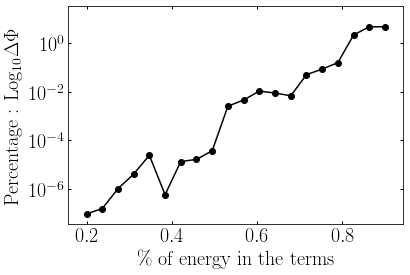

In [479]:
fig, ax  = plt.subplots()
plt.errorbar(e_cuts, np.abs(pot_mean_all), yerr=(pot_disp_all), c='k')
plt.scatter(e_cuts, np.abs(pot_mean_all), c='k')

ylabel(r'Percentage : $\rm{Log_{10}} \Delta \Phi$ ')
ax.set_yscale('log')
labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[1] = '$80 \%$'
#labels[2] = '$60 \%$'
#labels[3] = '$80 \%$'
#labels[4] = '$80 \%$'
xlabel('$\%$ of energy in the terms')
#savefig('pot_convergence.pdf', bbox_inches='tight')

In [98]:
N_particules = np.random.randint(0, len(MW_post[0]), 10000)

In [232]:
pot_mwlmc_biff = biff.potential(np.double(MW_post[0][N_particules]), S_matrix, T_matrix, G=G_gadget, M=1, r_s=r_s_sims)

In [393]:
a_mwlmc_biff = biff.gradient(np.double(MW_post[0][N_particules]), S_matrix, T_matrix, G=G_gadget, M=1, r_s=r_s_sims)

In [96]:
pot_mwlmc_biff_sim = biff.potential(np.ascontiguousarray(np.double(pos_pot_eval)), S_matrix, T_matrix, G=G_gadget, M=1, r_s=r_s_sims)

In [395]:
a_mwlmc_biff_sim = biff.gradient(np.ascontiguousarray(np.double(pos_pot_eval)), S_matrix, T_matrix, G=G_gadget, M=1, r_s=r_s_sims)

In [94]:
r_pot = np.logspace(0, 2.5, 100)

In [95]:
pos_pot_eval= np.array([r_pot, np.zeros(100), np.zeros(100)]).T

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


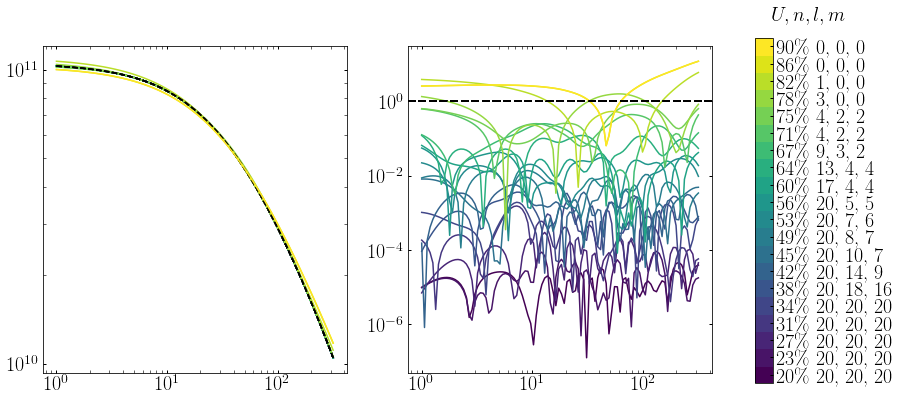

In [584]:
c1 = np.arange(0., 20)
cmap1 = plt.get_cmap("viridis", len(c1))
norm1 = matplotlib.colors.BoundaryNorm(np.arange(len(c1)+1),len(c1))
sm1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap1)
sm1.set_array([])


coeff_order = np.zeros((len(e_cuts),3))
j=0
fig = figure(figsize=(12, 6))

for i in e_cuts:
        S, T, coeff_order[j] = coefficients_energy_level(S_matrix, T_matrix, i)
        pot_e = biff.potential(np.ascontiguousarray(np.double(pos_pot_eval)), S, T, G=G_gadget, M=1, r_s=r_s_sims)
        subplot(1, 2, 1)
        loglog(r_pot, np.abs(pot_mwlmc_biff_sim), c='k', ls='--')
        loglog(r_pot, np.abs(pot_e), c=cmap1(j))

        subplot(1, 2, 2)
        loglog(r_pot, (np.abs(100*(pot_mwlmc_biff_sim-pot_e)/pot_mwlmc_biff_sim)), c=cmap1(j))
        axhline(1, ls='--', c='k', lw=2)

        j+=1

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm1, cax=cb_ax)

list_coeff_1 = []

for i in range(20):
    list_coeff_1.append(str(int(e_cuts[i]*100)) + '\% ' +str(int(coeff_order[i][0])) + ', ' + str(int(coeff_order[i][1])) + ', ' + str(int(coeff_order[i][2])))

text(0.93, 1.05, '$U, n, l, m$')
#set the colorbar ticks and tick labels
cbar.set_ticks(0.5 + np.arange(0, 21, 1))
cbar.set_ticklabels(list_coeff_1)

savefig('pot_convergence.pdf', bbox_inches='tight')

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


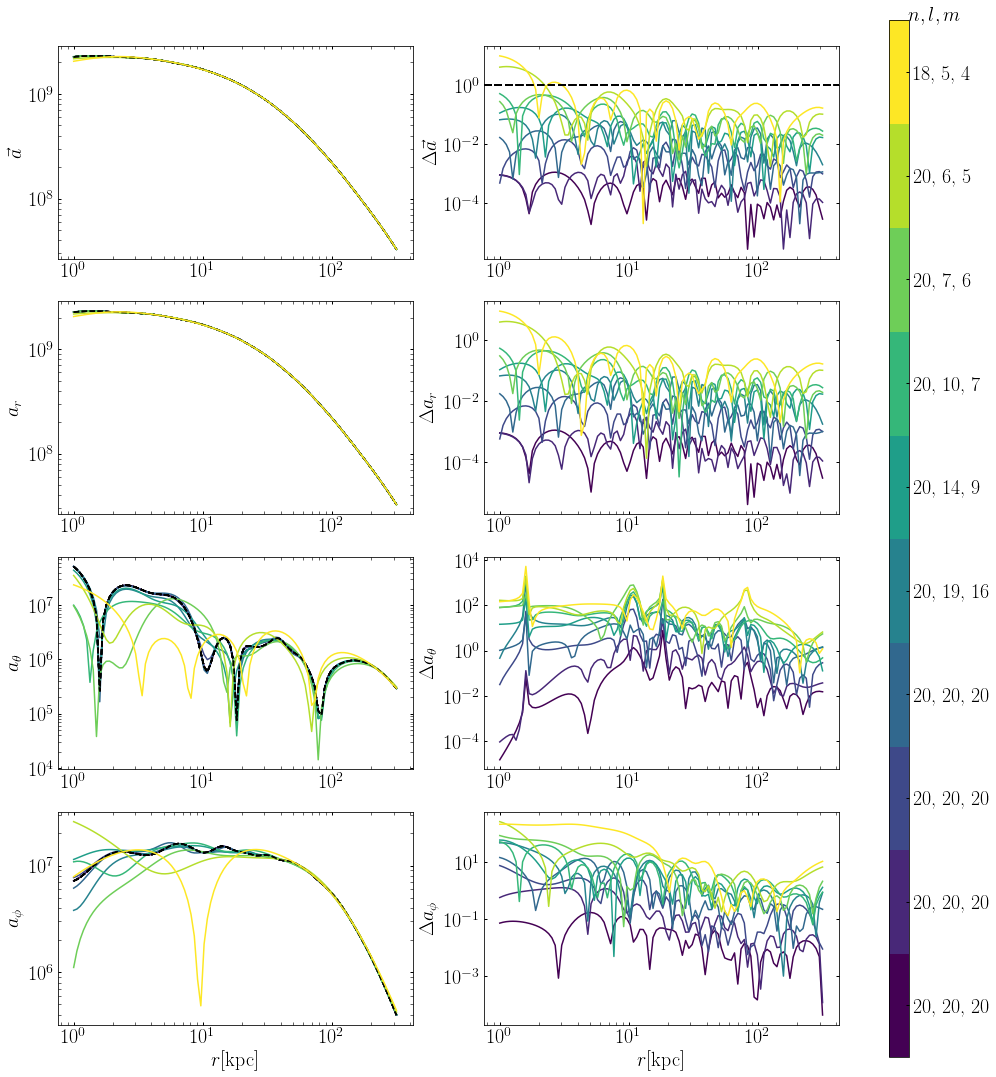

In [586]:
e_cuts2 = np.linspace(0.2, 0.6, 10)

c1 = np.arange(0., 10 )
cmap1 = plt.get_cmap("viridis", len(c1))
norm1 = matplotlib.colors.BoundaryNorm(np.arange(len(c1)+1),len(c1))
sm1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap1)
sm1.set_array([])


coeff_order = np.zeros((len(e_cuts2),3))
j=0
fig = figure(figsize=(14, 18))
a_vec = (a_mwlmc_biff_sim[:,0]**2 + a_mwlmc_biff_sim[:,1]**2 +  a_mwlmc_biff_sim[:,2]**2)**0.5

for i in e_cuts2:
        S, T, coeff_order[j] = coefficients_energy_level(S_matrix, T_matrix, i)
        grad_e = biff.gradient(np.ascontiguousarray(np.double(pos_pot_eval)), S, T, 
                               G=G_gadget, M=1, r_s=r_s_sims)

        subplot(4, 2, 1)
        a_sim = (grad_e[:,0]**2 + grad_e[:,1]**2 + grad_e[:,2]**2)**0.5

        loglog(r_pot, np.abs(a_vec), c='k', ls='--')
        loglog(r_pot, np.abs(a_sim), c=cmap1(j))
        ylabel(r'$\vec{a}$')

        subplot(4, 2, 2)
        loglog(r_pot, 100*(np.abs((a_sim-a_vec)/a_sim)), c=cmap1(j))
        ylabel(r'$\Delta \vec{a}$')
        axhline(1, c='k', ls='--', lw=2)
    
        subplot(4, 2, 3)
        loglog(r_pot, np.abs(a_mwlmc_biff_sim[:,0]), c='k', ls='--')
        loglog(r_pot, np.abs(grad_e[:,0]), c=cmap1(j))
        ylabel('$a_r$')

        subplot(4, 2, 4)
        loglog(r_pot, 100*(np.abs((a_mwlmc_biff_sim[:,0]-grad_e[:,0])/a_mwlmc_biff_sim[:,0])), c=cmap1(j))
        ylabel(r'$\Delta a_r$')

        subplot(4, 2, 5)
        loglog(r_pot, np.abs(a_mwlmc_biff_sim[:,1]), c='k', ls='--')
        loglog(r_pot, np.abs(grad_e[:,1]), c=cmap1(j))
        ylabel(r'$a_{\theta}$')

        subplot(4, 2, 6)
        loglog(r_pot, 100*(np.abs((a_mwlmc_biff_sim[:,1]-grad_e[:,1])/a_mwlmc_biff_sim[:,1])), c=cmap1(j))
        ylabel(r'$\Delta a_{\theta}$')

        subplot(4, 2, 7)
        loglog(r_pot, np.abs(a_mwlmc_biff_sim[:,2]), c='k', ls='--')
        loglog(r_pot, np.abs(grad_e[:,2]), c=cmap1(j))
        ylabel(r'$a_{\phi}$')
        xlabel(r'$r$[kpc]')

        subplot(4, 2, 8)
        loglog(r_pot, 100*(np.abs((a_mwlmc_biff_sim[:,2]-grad_e[:,2])/a_mwlmc_biff_sim[:,2])), c=cmap1(j))
        ylabel(r'$\Delta a_{\phi}$')
        xlabel(r'$r$[kpc]')

        
        j+=1
        
cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm1, cax=cb_ax)

list_coeff_1 = []

for i in range(10):
    list_coeff_1.append(str(int(coeff_order[i][0])) + ', ' + str(int(coeff_order[i][1])) + ', ' + str(int(coeff_order[i][2])))

text(0.93, 1, '$n, l, m$')
#set the colorbar ticks and tick labels
cbar.set_ticks(0.5 + np.arange(0, 12, 1))
cbar.set_ticklabels(list_coeff_1)

savefig('a_convergence.pdf', bbox_inches='tight')

In [99]:
r_mwlmc = (MW_post[0][N_particules,0]**2 + MW_post[0][N_particules,1]**2 + MW_post[0][N_particules,2]**2)**0.5

In [107]:
N_particules2 = np.random.randint(0, 10**6, 10000)

In [108]:
r_halo = (pos_dm_halo[N_particules2,0]**2 + pos_dm_halo[N_particules2,1]**2 + pos_dm_halo[N_particules2,2]**2)**0.5

In [112]:
MW_post[2]

array([-126377.9140625, -122277.7421875, -126060.046875 , ...,
        -78058.8359375,  -78207.671875 ,  -78464.6328125], dtype=float32)

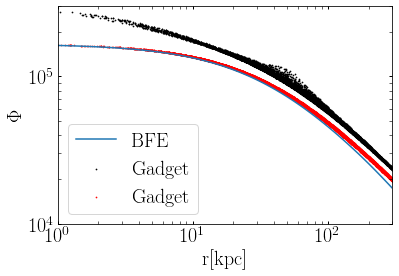

In [115]:
ax = subplot(1, 1, 1)
ax.scatter((r_mwlmc), (np.abs(MW_post[2][N_particules])), c='k', s=0.5, label='Gadget')
ax.plot((r_pot), (np.abs(pot_mwlmc_biff_sim*MW_mass[0])), label='BFE')


ax.scatter((r_halo), (np.abs(pot_dm_halo[N_particules2]*100)), c='r', s=0.5, label='Gadget')
#ax.plot((r_pot), (np.abs(pot_mwlmc_biff_sim*MW_mass[0])), label='BFE')


ax.legend()
ax.set_ylabel(r'$\Phi$')
ax.set_xlabel('r[kpc]')
ax.set_yscale('log')
ax.set_xscale('log')

xlim(1, 300)
ylim(1E4, 3E5)

savefig('gadget_bfe.png', bbox_inches='tight')